In [1]:
%%capture
pip install -U langgraph langchain_community langchain_cohere tavily_python pandas transformers accelerate sentencepiece datasets pydub soundfile datasets

# DB Setup

In [2]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"

def write_db (backup_file=backup_file, local_file=local_file, db_url=db_url, overwrite=False):
  if overwrite or not os.path.exists(local_file):
      response = requests.get(db_url)
      response.raise_for_status()  # Ensure the request was successful
      with open(local_file, "wb") as f:
          f.write(response.content)
      # Backup - we will use this to "reset" our DB in each section
      shutil.copy(local_file, backup_file)
  # Convert the flights to present time for our tutorial
  conn = sqlite3.connect(local_file)
  cursor = conn.cursor()

  tables = pd.read_sql(
      "SELECT name FROM sqlite_master WHERE type='table';", conn
  ).name.tolist()
  tdf = {}
  for t in tables:
      tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

  example_time = pd.to_datetime(
      tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
  ).max()
  current_time = pd.to_datetime("now").tz_localize(example_time.tz)
  time_diff = current_time - example_time

  tdf["bookings"]["book_date"] = (
      pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
      + time_diff
  )

  datetime_columns = [
      "scheduled_departure",
      "scheduled_arrival",
      "actual_departure",
      "actual_arrival",
  ]
  for column in datetime_columns:
      tdf["flights"][column] = (
          pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
      )

  for table_name, df in tdf.items():
      df.to_sql(table_name, conn, if_exists="replace", index=False)
  del df
  del tdf
  conn.commit()
  conn.close()

  db = local_file  # We'll be using this local file as our DB in this tutorial

In [3]:
write_db()
db = local_file

In [4]:
import os

os.environ['TAVILY_API_KEY'] = "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"
os.environ['COHERE_API_KEY'] = 'DWrjKmPLA3Op1kyirFp1UWysxdkgCDsRmtc009bG'

# LLM Setups

## VectorDB and Policy

In [5]:
import re

import numpy as np
from langchain_core.tools import tool
from langchain_cohere import CohereEmbeddings

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
      self._arr = np.array(vectors)
      self._docs = docs
      self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
      model="embed-english-v3.0"
      embeddings = oai_client(model=model).embed_documents([doc["page_content"] for doc in docs])
      vectors = [emb for emb in embeddings]
      return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
      model="embed-english-v3.0"
      embed = self._client(model=model).embed_query(text=query)
      # "@" is just a matrix multiplication in python
      scores = np.array(embed) @ self._arr.T
      top_k_idx = np.argpartition(scores, -k)[-k:]
      top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
      return [
          {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
      ]


retriever = VectorStoreRetriever.from_docs(docs, CohereEmbeddings)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

## Flights

In [6]:
# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from datetime import date, datetime
from typing import Optional

class fetch_user_flight_information_Input(BaseModel):
    pass

class search_flights_Input(BaseModel):
    departure_airport: Optional[str] = Field(description="The departure airport code")
    arrival_airport: Optional[str] = Field(description="The arrival airport code")
    start_time: Optional[date | datetime] = Field(
        description="must be empty or in iso format, specifies date or datetime for search lower band"
    )
    end_time: Optional[date | datetime] = Field(
        description="must be empty or in iso format, specifies date or datetime for search upper band"
    )
    limit: Optional[int] = Field(description="specifies the maximum number of search results")

class update_ticket_to_new_flight_Input(BaseModel):
    ticket_no: str = Field(description="should be the user's ticket number")
    new_flight_id: int = Field(description="should be a new flight id")

class cancel_ticket_Input(BaseModel):
    ticket_no: str = Field(description="should be the user's ticket number")


In [7]:
import sqlite3

import pytz
from langchain_core.runnables import ensure_config

@tool("fetch_user_flight_information", args_schema=fetch_user_flight_information_Input, return_direct=False)
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool("search_flights", args_schema=search_flights_Input, return_direct=False)
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

@tool("update_ticket_to_new_flight", args_schema=update_ticket_to_new_flight_Input, return_direct=False)
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool("cancel_ticket", args_schema=cancel_ticket_Input, return_direct=False)
def cancel_ticket(ticket_no: str) -> str:
    """Cancel the user's ticket and remove it from the database."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

## Utilitize

In [8]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## State

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Image2Text model

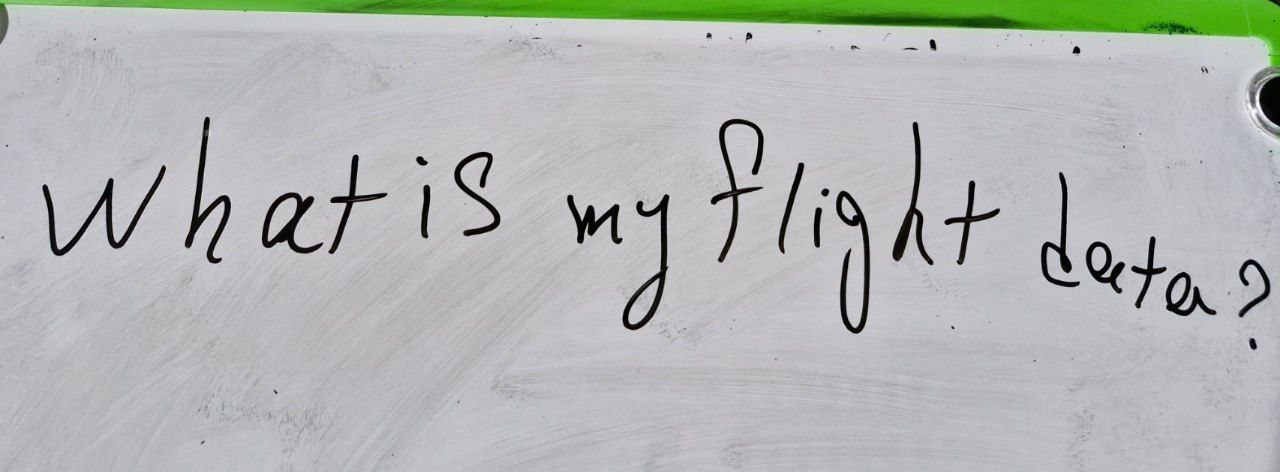

In [10]:
from PIL import Image

# Path to your local image
img_path = '/content/un.jpg'

# Open the local image
raw_image = Image.open(img_path).convert('RGB')
raw_image

In [11]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests


def Img2Text(img_path):
    processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
    model_img = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')

    # Open the local image
    raw_image = Image.open(img_path).convert('RGB')
    # raw_image

    # process image and generate text
    pixel_values = processor(images=raw_image, return_tensors="pt").pixel_values

    generated_ids = model_img.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

In [23]:
# Path to image
img_path = '/content/un.jpg'

# extract question from image
img_text = Img2Text(img_path)

img_text

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'what is my flight deter?'

## Speech2Text model

In [12]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline


def S2T(audio_path):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

    model_id = "openai/whisper-tiny"

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
    )
    model.to(device)

    processor_audio = AutoProcessor.from_pretrained(model_id)
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor_audio.tokenizer,
        feature_extractor=processor_audio.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=30,
        batch_size=16,
        return_timestamps=True,
        torch_dtype=torch_dtype,
        device=device,
    )
    result = pipe(audio_path, generate_kwargs={"language": "english"})
    return result['text']

In [18]:
# read question from audio
audio_path="/content/ttsmaker-file-2024-5-30-11-25-36.mp3"
result_audio = S2T(audio_path)
result_audio

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


' Am I allowed to update my flight to something sooner? I want to leave later today.'

In [21]:
from IPython.display import Audio

def play_audio(file_path):
    display(Audio(file_path))

play_audio('/content/ttsmaker-file-2024-5-30-11-25-36.mp3')

## Text2Speech

In [24]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
import torch
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
import soundfile as sf
from datasets import load_dataset

def generate_speech(text):
    # Load the processor and model
    processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
    model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
    vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

    # Prepare the inputs
    inputs = processor(text=text, return_tensors="pt")


    # Speaker Embedding
    # load xvector containing speaker's voice characteristics from a dataset
    embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
    speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

    # Generate speech
    with torch.no_grad():
        speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

    # Save the audio to a file
    sf.write("output.wav", speech.numpy(), 16000)

    return "output.wav"

In [25]:
# Example usage
text = "Hello, how can I help you today?"
audio_file = generate_speech(text)
play_audio(audio_file)

## Assistant

In [14]:
SYSTEM_PROMPT_TEMPLATE = \
"""
You are a helpful customer support assistant for Iran Airlines.
Use the provided tools to search for flights, company policies, and other information to assist the user's queries.
When searching, be persistent. Expand your query bounds if the first search returns no results.
If a search comes up empty, expand your search before giving up.

You have access to the following tools to get more information if needed:

{tool_descs}

You also have access to the history of previous messages.
Return your response as a JSON blob with keys as a dict type.

If you have any questions from the user, put that in `FINAL_ANSWER` as well.

At each time you can not use more than one tool, you have to choose one tool when you want to fill "ACTION" param

JSON blob when you need to use a tool MUST have ONLY following keys:

"THOUGHT": "<you should always think about what to do>",
"ACTION": "<the action to take, must be one tool_name from above tools>",
"ACTION_PARAMS": "<the input parameters to the ACTION, it must be in json format complying with the tool_params>"

JSON blob when you do not need to use a tool MUST have ONLY following keys:
"THOUGHT": "<you should always think about what to do>",
"FINAL_ANSWER": "<a text containing the final answer to the original input question>",


Always you have to look at the previous messages and try to find answer from them and if you can find answer of user's question from previous messages then put answer in "FINAL_ANSWER".

Always make sure that your output is a JSON blob complying with above format.
Do NOT add anything before or after the json response.

Current time: {time}.
"""

In [15]:
from langchain_cohere import ChatCohere
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing import List
from langchain_core.tools import BaseTool
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_core.output_parsers import JsonOutputParser
import warnings
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage, ToolCall, ToolMessage
import json
from langchain.tools.render import render_text_description_and_args

class Assistant:
    def __init__(self, runnable: Runnable, tools: List[BaseTool]):
        self.runnable = runnable
        self.tools = tools

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            if isinstance(state['messages'][-1], ToolMessage):
                if not state['messages'][-1].content:
                    state['messages'][-1].content = 'Checked parameters of called tool again and return a Json Blob with correct and alternative parameters \
                        in "ACTION_PARAMS"'
            result = self.runnable.invoke(state, config)
            try:
                if result.content == '':
                    # no answer from model
                    warnings.warn('WRONG EMPTY RESPOND: ' + result.content)
                    final_answer = ""
                    break

                parser = JsonOutputParser()
                content_json = parser.invoke(result.content)
            except ValueError as e:
                warnings.warn('BAD FORMAT: \n' + result.content)
                state['messages'] += [result, HumanMessage("Respond with a valid json output!")]
                continue

            if isinstance(content_json, list):
                content_json = content_json[0]
                # print(content_json)

            action = content_json.get('ACTION', '').replace(' ', '')
            action_params = content_json.get('ACTION_PARAMS') or {}
            if type(action_params) is str:
                action_params = json.loads(action_params)
            final_answer = content_json.get('FINAL_ANSWER')


            if action and action not in [tool.name for tool in self.tools]:
                warnings.warn('BAD TOOL NAME: ' + result.content)
                state['messages'] += [result, HumanMessage(f"The ACTION `{action}` does not exist!")]
                continue
            break

        if action and not final_answer:
            tool_call = ToolCall(name=action, args=action_params, id=str(uuid.uuid4()))
            result.tool_calls.append(tool_call)
            return {'messages': result}

        elif not final_answer:
            en_final_answer = "No results from model"
            audio_file = generate_speech(en_final_answer)
            play_audio(audio_file)
            final_result = AIMessage(en_final_answer)
        else:
            audio_file = generate_speech(final_answer)
            play_audio(audio_file)
            final_result = AIMessage(final_answer)

        return {'messages': [result, final_result]}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatCohere(temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
]


tools_descr = render_text_description_and_args(part_1_tools)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",SYSTEM_PROMPT_TEMPLATE
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_assistant_runnable = primary_assistant_prompt.partial(tool_descs=tools_descr) | llm

## Define Graph

In [16]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable, part_1_tools))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

In [ ]:
# write_db()
# db = local_file

# Conversation

In [27]:
import shutil
import uuid
import warnings
from transformers.utils import logging

warnings.filterwarnings("ignore")
logging.set_verbosity_error()
# Let's create an example conversation a user might have with the assistant
tutorial_questions = []


# # Path to your local image
img_path = '/content/un.jpg'

# extract question from image
img_text = Img2Text(img_path)

tutorial_questions.append(img_text)

# read question from audio
audio_path="/content/ttsmaker-file-2024-5-30-11-25-36.mp3"
result_audio = S2T(audio_path)

tutorial_questions.append(result_audio)


# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {'messages': question}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

what is my flight deter?
================================== Ai Message ==================================

```json
{
    "THOUGHT": "The user is asking about their flight details. I can find this information by fetching their flight information.",
    "ACTION": "fetch_user_flight_information",
    "ACTION_PARAMS": {}
}
```
Tool Calls:
  fetch_user_flight_information (3892b3fe-5e43-4e4b-bfb7-9c46790d6eb3)
 Call ID: 3892b3fe-5e43-4e4b-bfb7-9c46790d6eb3
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-04-30 12:09:03.561731-04:00", "scheduled_arrival": "2024-04-30 13:39:03.561731-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]


================================== Ai Message ==================================

Your flight is LX0112, departing from CDG and arriving at BSL. The scheduled departure time is 12:09 and the scheduled arrival time is 13:39. You are seated in seat 18E and your ticket number is 7240005432906569.
================================ Human Message =================================

 Am I allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================

```json
{
 "THOUGHT": "I will consult company policy to check if the user is allowed to update their flight.",
 "ACTION": "lookup_policy",
 "ACTION_PARAMS": {
 "query": "Can customers update their flight to an earlier time on the day of departure?"
 }
}
```
Tool Calls:
  lookup_policy (de65ffd2-4eeb-4514-a3ef-68262cd38c2d)
 Call ID: de65ffd2-4eeb-4514-a3ef-68262cd38c2d
  Args:
    query: Can customers update their flight to an earlier time on the day of

================================== Ai Message ==================================

I can certainly look into updating your flight to an earlier time. To do this, I will need to know your ticket number. Also, please note that the minimum time before departure for online rebookings depends on your departure airport. For example, if you are departing from a Swiss airport, you can rebook online up to three hours before departure.
